In [1]:
from IPython.display import Image

## basics

- 为什么要学 KD
    - 必要；
        - GPT 时代
        - 业务所需；
    - 模型结构（分支）和损失函数的设计，值得借鉴
- openai GPT 一骑绝尘的时代，GPT4 就是老师；
- Teacher-Student paradigm
    - 在训练中将 teacher 的知识蒸馏/transfer 到 student model 中；
        - 对于 student model 而言，就是 mimic（模仿）的过程；
    - teacher：larger，slower，better-performing
    - student：smaller, faster, cheaper and lighter
- 2006年提出来，是在 ensemble models（集成模型）的语境下提出来的；
    - 2015年，引入到深度学习；
- 本节的重点是知识蒸馏的 **模型架构**（loss Function） 及 **Pipeline**；

## 理论初步

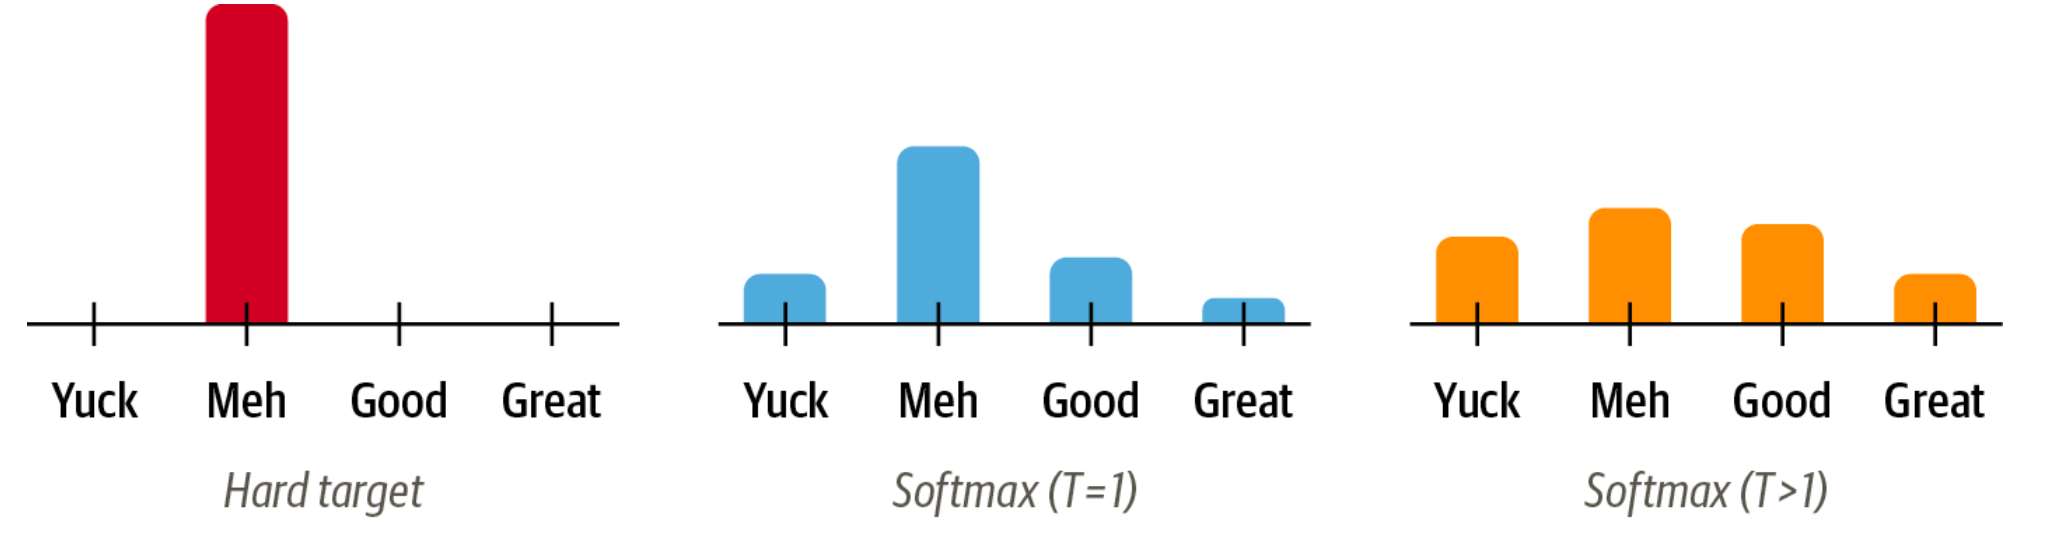

In [27]:
Image('../imgs/dist.png', width=600)

- 理论方面
    - Student model 学的不是一个 single value（one-hot representation），而是 teacher model 预测的概率分布（dense feature representation）；
    - 关于多分类问题的输出
        - ground truth：hard target，one-hot encoding
        - Teacher predict output：softmax ($T=1$)
            - soften probabilities ($T>1$)
    
- 假如对于一个有监督的分类问题，对于样本 $x$，
    - 对于 Teacher model，其 output（logits） 为 $\mathbf z(x)=[z_1(x),z_2(x),\cdots,z_N(x)]$
        - 将其进一步通过 softmax（with temperature）转化为概率化的输出：
$$
p_i(x)=\frac{\exp\left(\frac{z_i(x)}T\right)}{\sum_j\exp\left(\frac{z_j(x)}{T}\right)}
$$

    - 对于 Student model，其预测的概率分布为 $q_i(x)$
    - 此时使用 KL-divergence（KL-散度）来度量两个概率分布的距离（或者叫差异）
    
$$
D_{KL}(p,q)=\sum_ip_i(x)\log\frac{p_i(x)}{q_i(x)}\\
L_{KD}=T^2D_{KL}
$$
- 通过 KL-divergence，也度量了当 Student model（用 $q_i(x)$）来逼近/近似 Teacher model （用 $p_i(x)$）的信息损失；

$$
\begin{split}
L_{\text{student}}&=\alpha L_{\text{CE}} + (1-\alpha)L_{KD}\\
&=\alpha L_{\text{CE}} + (1-\alpha)T^2D_{KL}
\end{split}
$$

## 模型结构

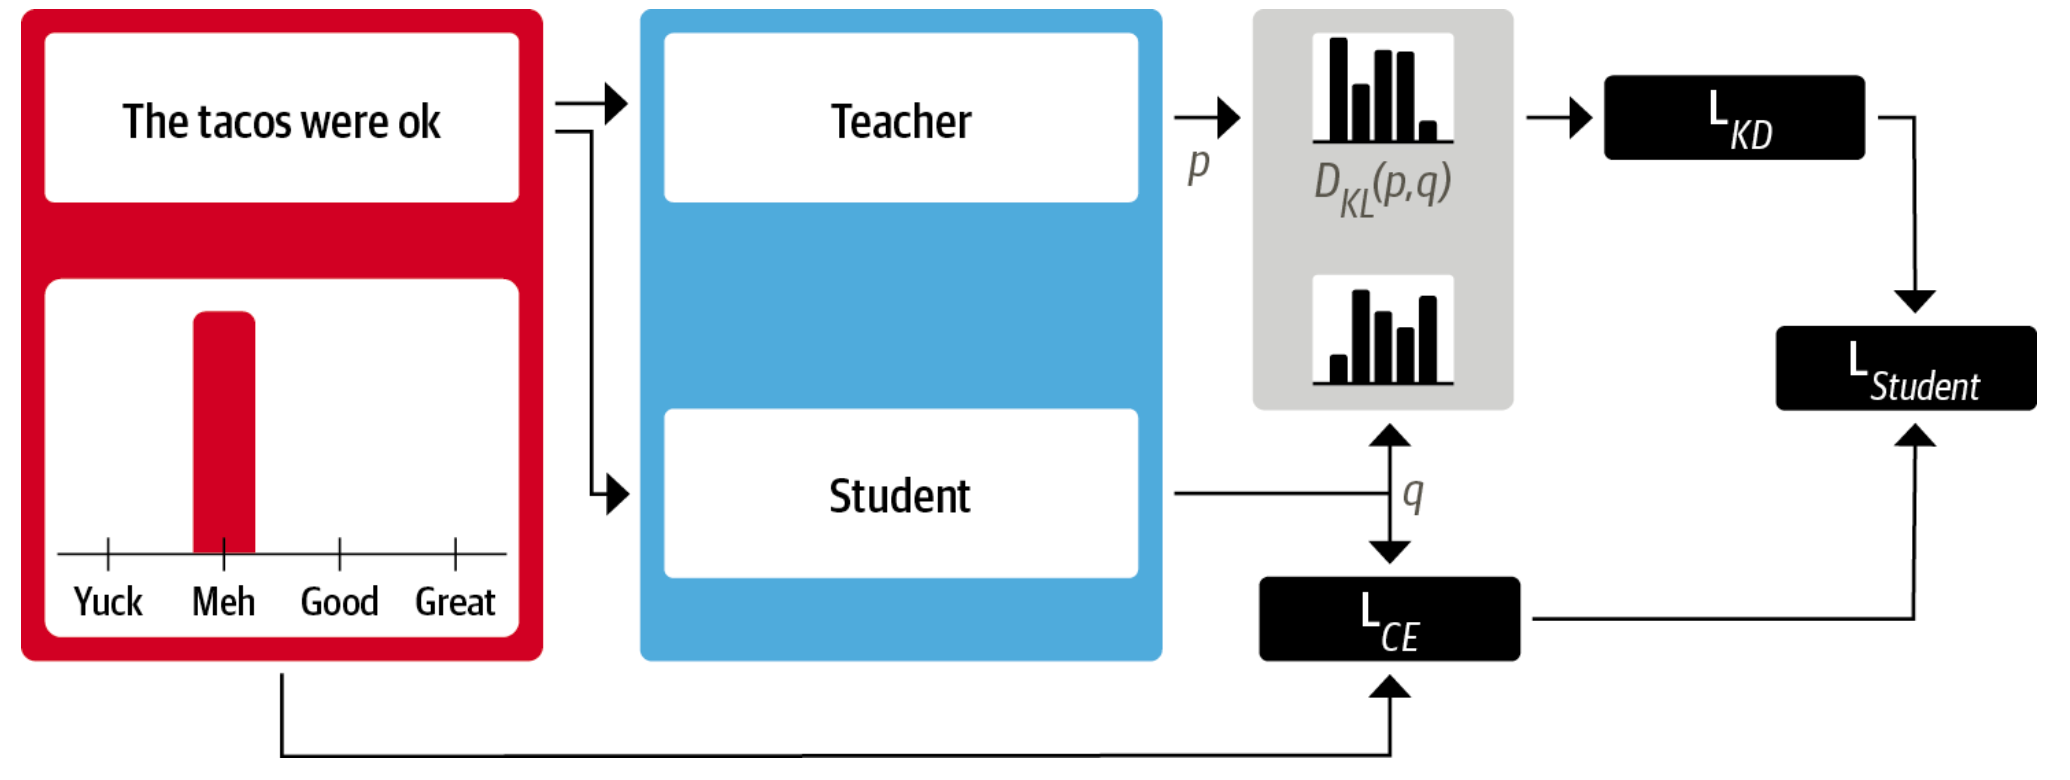

In [4]:
Image('../imgs/kd.png', width=500)

## kd on pretraining

- BERT 开启了一个范式：pretraining + downstream tasks
- 同样地对 pretraining model （比如 BERT）进行 distill 得到 DistilBert
    - https://arxiv.org/abs/1910.01108（DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter
）
        - https://medium.com/huggingface/distilbert-8cf3380435b5
    - $L_{cos}=1-\cos(h_s,h_t)$  不只是对齐输出，还对齐（align）direction of hidden state vectors（representation space）
$$
\begin{split}
L_{\text{distil-bert}}&=\alpha L_{\text{mlm}} + \beta L_{KD} + \gamma L_{cos}\\
&=\alpha L_{\text{mlm}} + \beta L_{KD} + \gamma (1-\cos(h_s,h_t))
\end{split}
$$

In [5]:
from transformers import AutoModel, AutoTokenizer

In [9]:
import os
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:7890'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:7890'

In [18]:
model = AutoModel.from_pretrained('bert-base-uncased')
kd_model = AutoModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 

In [28]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [29]:
kd_model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [30]:
def model_size(model):
    return sum(para.numel() for para in model.parameters())

In [31]:
print(model_size(model))
print(model_size(kd_model))
print(model_size(kd_model)/model_size(model))

109482240
66362880
0.6061520115043316
